Autors: Pablo Aguilar Ruiz (1636546) - Guillem Gusart Verdú (1636054)

GitHub: https://github.com/NIU1636546/Cardiovascular-Disease-Prediction.git

# Cas Kaggle: Predicció de Malalties Cardiovasculars

Les malalties cardiovasculars són una de les principals causes de mortalitat arreu del món. Aquest cas de Kaggle té com a objectiu utilitzar dades mèdiques de pacients per desenvolupar models d'aprenentatge automàtic capaços de predir si un pacient té risc de patir una malaltia cardiovascular.

## 1. Objectiu:
El repte consisteix a analitzar un conjunt de dades mèdiques, identificar patrons i construir un model predictiu que pugui classificar els pacients en dues categories:
- **0**: No té malaltia cardiovascular.
- **1**: Té malaltia cardiovascular.

Aquesta classificació pot ajudar els professionals mèdics a identificar pacients d'alt risc de manera més eficient i amb menys recursos.

## 2. Descripció del Dataset:
El dataset inclou dades mèdiques de pacients, com ara:
- **Edat, gènere, alçada i pes**: Factors demogràfics i físics.
- **Pressió arterial**: Indicadors clau de salut cardiovascular.
- **Colesterol i glucosa**: Mesures bioquímiques importants.
- **Hàbits personals**: Fumar, consum d'alcohol i activitat física.

Totes aquestes variables han estat analitzades i pre-processades per garantir un modelatge eficient.

## 3. Enfocament del Projecte:
Per aconseguir l'objectiu, hem seguit aquests passos:
1. **Visualització de les dades**: Es començarà analitzant les dades de manera gràfica per comprendre la distribució de les variables.
2. **Exploració de les dades**: Es realitzarà un anàlisi descriptiva per identificar relacions entre les variables, detectar possibles anomalies i determinar quines poden tenir un major impacte en la predicció de malalties cardiovasculars.
3. **Preparació de les dades**: Es duran a terme passos clau de preprocessament, com la codificació de variables categòriques, el tractament d'outliers i la divisió de les dades en conjunts d'entrenament i prova per garantir una avaluació justa dels models.
4. **Selecció del model**: Es provaran diferents algoritmes de classificació, començant per un model lineal com la Logistic Regression per establir una línia base, i explorant després models més complexos com XGBoost per millorar el rendiment global.

Aquest enfocament combina anàlisi exploratòria i tècniques avançades d'aprenentatge automàtic per obtenir un model robust i aplicable a situacions reals.

In [161]:
#Importar llibreries necessàries per a l'entrenament del model
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from xgboost import DMatrix, train

In [162]:
# Carregar les dades
train_data=pd.read_csv('cardio_train.csv', delimiter=';')

## 1. Visualització de les dades

In [163]:
# Anàlisi de tipus de variable i nulls que conté
# Resum de les columnes i els seus tipus de dades després de corregir
columns_summary = train_data.dtypes.reset_index()
columns_summary.columns = ['Column', 'Dtype']
columns_summary['Non-Null Count'] = train_data.notnull().sum().values

columns_summary

,Column,Dtype,Non-Null Count
0,id,int64,70000
1,age,int64,70000
2,gender,int64,70000
3,height,int64,70000
4,weight,float64,70000
5,ap_hi,int64,70000
6,ap_lo,int64,70000
7,cholesterol,int64,70000
8,gluc,int64,70000
9,smoke,int64,70000


### Contingut del cardio_train.csv:

- **age**: Edat (en dies).
- **gender**: Gènere (1 per masculí, 2 per femení).
- **height**: Alçada (en cm).
- **weight**: Pes (en kg).
- **ap_hi**: Pressió arterial sistòlica.
- **ap_lo**: Pressió arterial diastòlica.
- **cholesterol**: Nivell de colesterol (1: normal, 2: alt, 3: molt alt).
- **gluc**: Nivell de glucosa (1: normal, 2: alt, 3: molt alt).
- **smoke**: Fuma (0: no, 1: sí).
- **alco**: Consumeix alcohol (0: no, 1: sí).
- **active**: Físicament actiu (0: no, 1: sí).
- **cardio**: Malaltia cardiovascular (0: no, 1: sí) (target)




Per assegurar-nos que no hi han valors nulls, fem una segona comprovació.

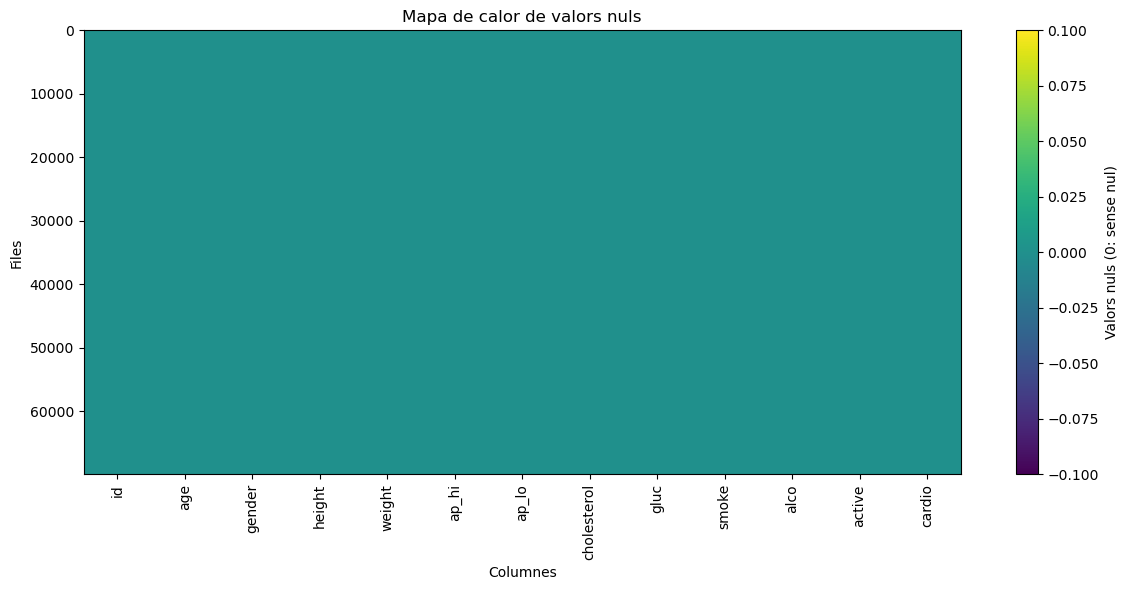

In [164]:
# Crear el mapa de calor per visualitzar valors nuls
plt.figure(figsize=(12, 6))
plt.title("Mapa de calor de valors nuls")
plt.imshow(train_data.isnull(), aspect="auto", cmap="viridis", interpolation="none")
plt.colorbar(label="Valors nuls (0: sense nul)")
plt.xlabel("Columnes")
plt.ylabel("Files")
plt.xticks(range(train_data.shape[1]), train_data.columns, rotation=90)
plt.tight_layout()
plt.show()


Aquí tenim un mapa de calor que mostra la presència de valors nuls al dataset. Com que no apareixen zones destacades, podem confirmar visualment que no hi ha valors nuls a cap columna. Això assegura que el dataset està complet per continuar amb el anàlisis.

## 2. Exploració de les dades

Actualment, la variable "age" està definida per dies, aquesta s'ha de canviar a anys perquè sigui més intuitiu.



In [165]:
# Convertir l'edat de dies a anys
train_data['age'] = (train_data['age'] / 365).astype(int)

# Visualitzar el canvi
train_data['age'].head()


0    50
1    55
2    51
3    48
4    47
Name: age, dtype: int32

A continuació, visualitzarem si existeixen valors anòmals en algunes variables clau com: height, weight, ap_hi, ap_lo i age

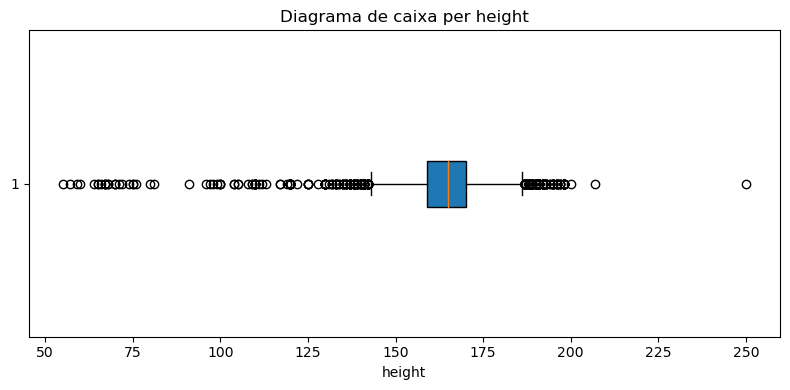

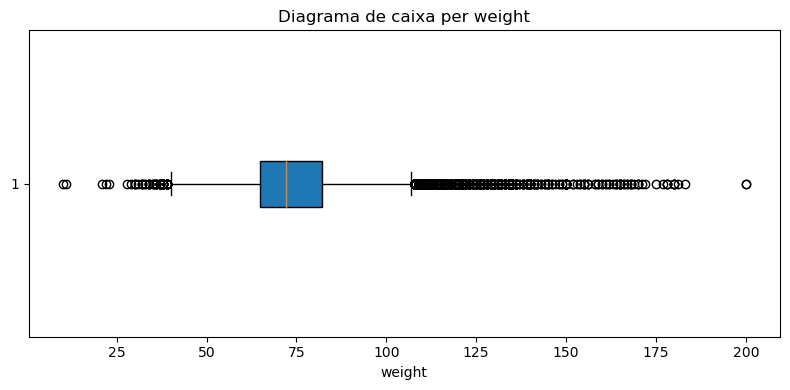

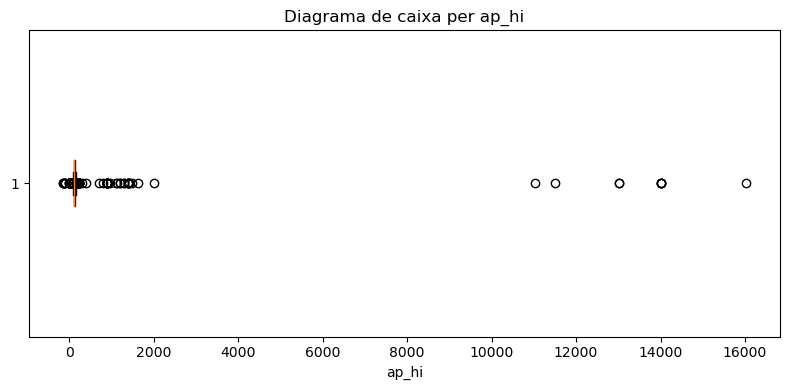

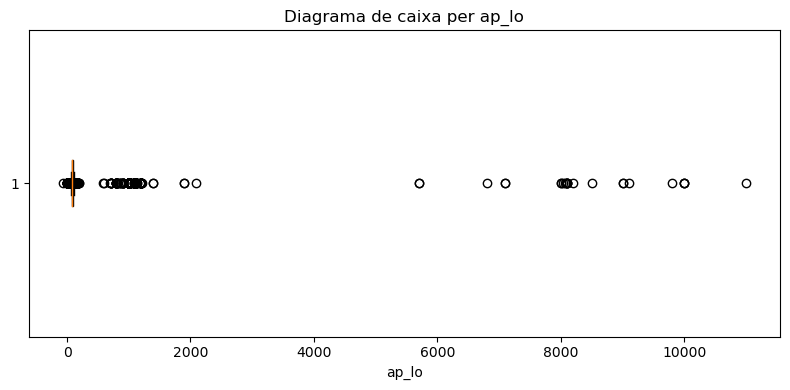

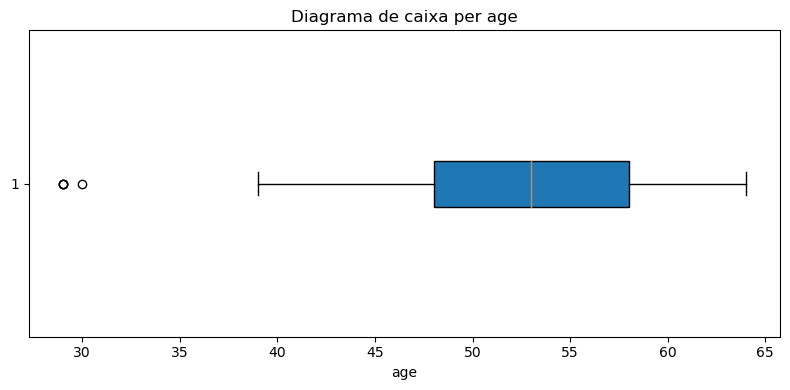

In [166]:
# Visualitzar valors anòmals amb boxplots per a variables clau
key_columns = ['height', 'weight', 'ap_hi', 'ap_lo', 'age']

# Crear els diagrames de caixa
for column in key_columns:
    plt.figure(figsize=(8, 4))
    plt.title(f"Diagrama de caixa per {column}")
    plt.boxplot(train_data[column], vert=False, patch_artist=True)
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()


Dels diagrames observem que:
- **height**: S'observen valors molt baixos (55 cm) i molt alts (fins a 250 cm), que són improbables.
- **weight**: Hi ha valors extrems, com pesos molt baixos (<25 kg) que poden ser anomalies.
- **ap_hi (pressió sistòlica)**: Valors extremadament alts (fins a 16,020) i negatius són irreals.
- **ap_lo (pressió diastòlica)**: De nou, valors molt alts (fins a 10,000) i negatius indiquen errors.

Per tractar aquests errors en les dades, aplicarem el següent filtre:
- **height**: Entre 130 i 220 cm.
- **weight**: Entre 30 i 200 kg.
- **ap_hi (pressió sistòlica)**: Entre 80 i 240.
- **ap_lo (pressió diastòlica)**: Entre 40 i 140.

In [167]:
# Aplicar filtres raonables per eliminar valors anòmals
filtered_data = train_data[
    (train_data['height'] >= 130) & (train_data['height'] <= 220) &  # Filtre per height
    (train_data['weight'] >= 30) & (train_data['weight'] <= 200) &  # Filtre per weight
    (train_data['ap_hi'] >= 80) & (train_data['ap_hi'] <= 240) &    # Filtre per ap_hi
    (train_data['ap_lo'] >= 40) & (train_data['ap_lo'] <= 140)      # Filtre per ap_lo
]

# Comprovar el nombre de files eliminades
removed_rows = train_data.shape[0] - filtered_data.shape[0]

filtered_data_summary = {
    "Files inicials": train_data.shape[0],
    "Files després de filtrar": filtered_data.shape[0],
    "Files eliminades": removed_rows
}

filtered_data_summary


{'Files inicials': 70000,
 'Files després de filtrar': 68636,
 'Files eliminades': 1364}

Tornem a crear els diagrames per visualitzar els canvis.

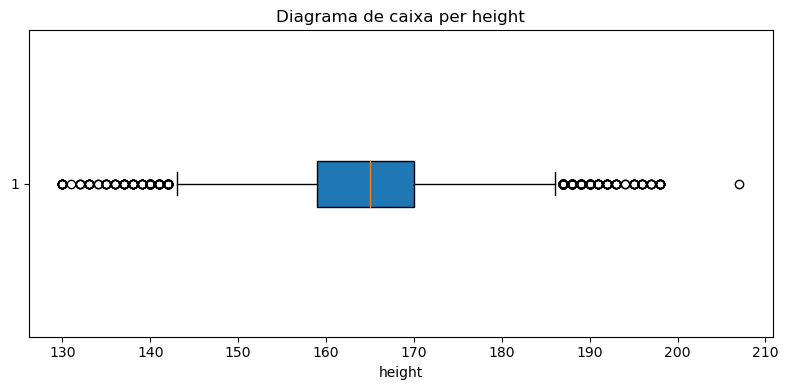

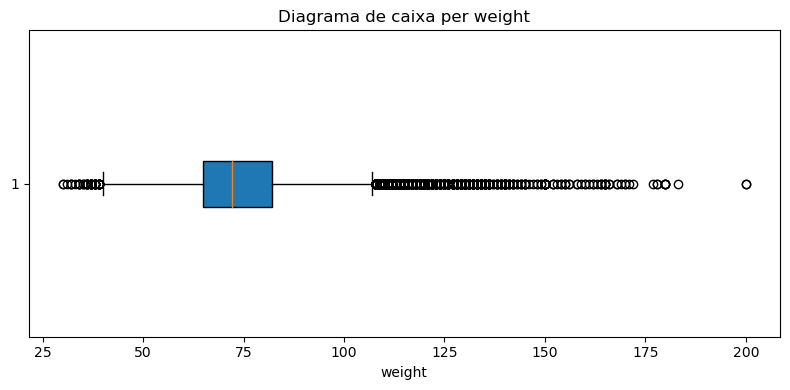

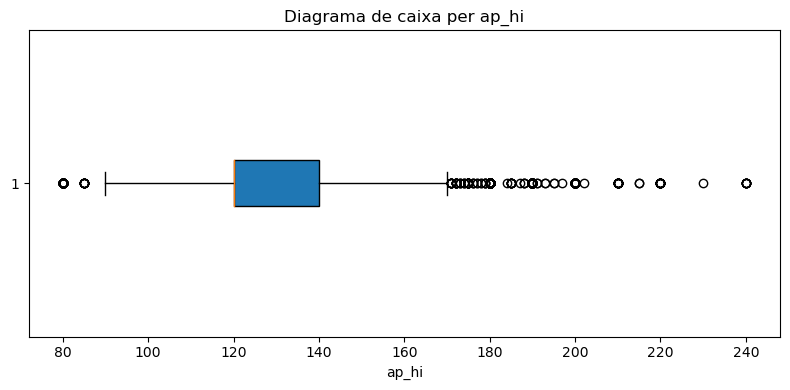

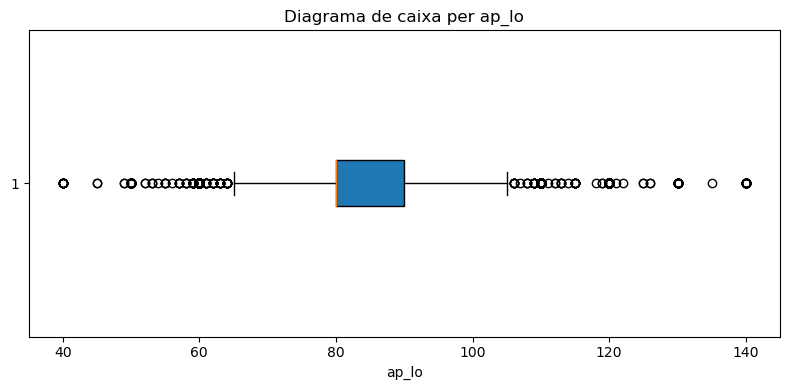

In [168]:
# Visualitzar valors anòmals amb boxplots per a variables clau
key_columns = ['height', 'weight', 'ap_hi', 'ap_lo']

# Crear els diagrames de caixa
for column in key_columns:
    plt.figure(figsize=(8, 4))
    plt.title(f"Diagrama de caixa per {column}")
    plt.boxplot(filtered_data[column], vert=False, patch_artist=True)
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()

Seguidament, identificarem relacions amb la variable cardio. Mitjançant la **matriu de correlacions**, mostrarem quines variables tenen més relació amb la variable objectiu.

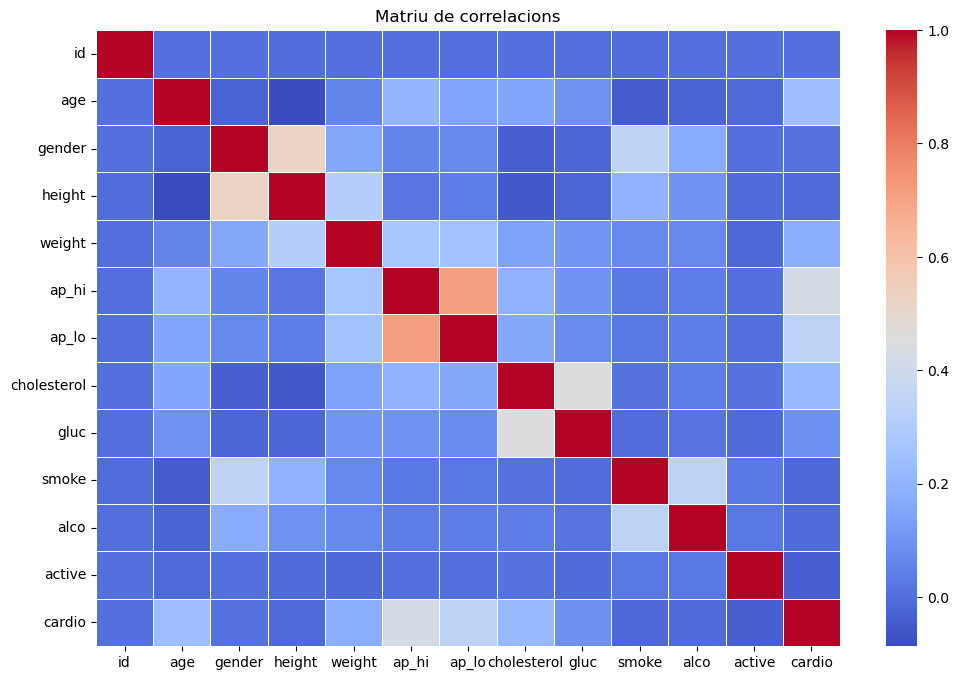

cardio         1.000000
ap_hi          0.425926
ap_lo          0.338706
age            0.239280
cholesterol    0.221500
weight         0.179800
gluc           0.089951
gender         0.007240
id             0.003554
alco          -0.008184
height        -0.012335
smoke         -0.016158
active        -0.037399
Name: cardio, dtype: float64

In [169]:
# Calcular la matriu de correlacions
correlation_matrix = filtered_data.corr()

# Mostrar la matriu de correlacions amb una heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriu de correlacions")
plt.show()

# Ordenar correlacions amb la variable objectiu 'cardio'
correlation_with_cardio = correlation_matrix['cardio'].sort_values(ascending=False)
correlation_with_cardio



## 3. Preparació de les dades

### Selecció de variables
Com hem vist a la matriu de correlacions, algunes de les variables actuals són insignificants pel model. Eliminem les variables del dataset que no superen el 0,00 (negatiu o positiu): id, gender i alco.

In [170]:
filtered_data = filtered_data.drop(columns=['id', 'gender', 'alco'])

# Comprovar que les columnes han estat eliminades
filtered_data.head()


,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio
0,50,168,62.0,110,80,1,1,0,1,0
1,55,156,85.0,140,90,3,1,0,1,1
2,51,165,64.0,130,70,3,1,0,0,1
3,48,169,82.0,150,100,1,1,0,1,1
4,47,156,56.0,100,60,1,1,0,0,0


### Conversió de dades categòriques

Amb la finalitat d'assegurar-nos que en les variables "cholesterol" i "gluc" no estem imposant un ordre que el model no necessita, apliquem la codificació One-Hot.

In [171]:
#Canviar de valors numérics a strings (1=normal, 2=above_normal, 3=well_above_normal)
filtered_data['cholesterol']=filtered_data['cholesterol'].apply(lambda x: 'normal' if x==1 else('above_normal' if x==2 else 'well_above_normal'))
filtered_data['gluc']=filtered_data['gluc'].apply(lambda x: 'normal' if x==1 else('above_normal' if x==2 else 'well_above_normal'))

# Aplicar One-Hot Encoding a 'cholesterol' i 'gluc'
encoded_data = pd.get_dummies(filtered_data, columns=['cholesterol', 'gluc'], prefix=['cholesterol', 'gluc'])

# Comprovar les noves columnes creades
encoded_data.head()

,age,height,weight,ap_hi,ap_lo,smoke,active,cardio,cholesterol_above_normal,cholesterol_normal,cholesterol_well_above_normal,gluc_above_normal,gluc_normal,gluc_well_above_normal
0,50,168,62.0,110,80,0,1,0,False,True,False,False,True,False
1,55,156,85.0,140,90,0,1,1,False,False,True,False,True,False
2,51,165,64.0,130,70,0,0,1,False,False,True,False,True,False
3,48,169,82.0,150,100,0,1,1,False,True,False,False,True,False
4,47,156,56.0,100,60,0,0,0,False,True,False,False,True,False


### Definició del conjunt

In [172]:
# Separar variables predictors (X) i la variable objectiu (y)
X = encoded_data.drop(columns=['cardio'])  # Variables predictors
y = encoded_data['cardio']  # Variable objectiu

# Dividir en conjunts d'entrenament i test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Comprovar la mida dels conjunts
split_summary = {
    "Mida del conjunt d'entrenament": X_train.shape[0],
    "Mida del conjunt de test": X_test.shape[0],
    "Nombre de característiques": X_train.shape[1]
}

split_summary


{"Mida del conjunt d'entrenament": 54908,
 'Mida del conjunt de test': 13728,
 'Nombre de característiques': 13}

## 4. Selecció del model

Amb la finalitat d'aconseguir el millor model, realitzarem estudis amb tres models diferents per observar el millor. Aquests tres són: Logistic Regression, Random Forest i Support Vector Machine.


In [173]:
# Definir models a entrenar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42)
}

# Entrenar i avaluar cada model
results = []

for model_name, model in models.items():
    # Entrenament
    model.fit(X_train, y_train)

    # Prediccions
    y_pred = model.predict(X_test)

    # Avaluació
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Afegir resultats
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Convertir resultats en DataFrame i mostrar-los
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.722684,0.751558,0.656756,0.700966
1,Random Forest,0.701705,0.700133,0.694878,0.697496
2,Support Vector Machine,0.718969,0.763555,0.625994,0.687965


Anàlisi dels resultats: com podem observar, el model Logistic Regression és el que millor s'ajusta a les nostres dades i per tant, l'escollit.

### Cross-Validation

Realitzarem Cross-Validation amb 5 folds per validar el rendiment del nostre model de Logistic Regression, que ja hem identificat com un candidat prometedor. Aquesta anàlisi ens ajudarà a confirmar si l'accuracy de 0.72 observada és consistent.

In [174]:
# Definir X i y
X = encoded_data.drop(columns=['cardio'])  # Variables predictors
y = encoded_data['cardio']  # Variable objectiu

# Crear el model Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Realitzar Cross-Validation
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')

# Resultats de Cross-Validation
cv_results = {
    "Mitjana de Accuracy": np.mean(cv_scores),
    "Desviació estàndard": np.std(cv_scores),
    "Accuracy per cada partició": cv_scores
}

# Mostrar resultats
print("Mitjana de Accuracy:", cv_results["Mitjana de Accuracy"])
print("Desviació estàndard:", cv_results["Desviació estàndard"])
print("Accuracy per cada partició:", cv_results["Accuracy per cada partició"])


Mitjana de Accuracy: 0.7275191311747916
Desviació estàndard: 0.002526464596904642
Accuracy per cada partició: [0.72443182 0.73104101 0.72754426 0.72951118 0.72506739]


Anàlisi dels resultats:
- Mitjana de Accuracy: 0.7275
    - Això mostra que el model de Logistic Regression té una precisió mitjana del 72.75% en predir correctament si un pacient té o no una malaltia cardiovascular.
- Desviació estàndard: 0.0025
    - La baixa desviació estàndard indica que el model és consistent i el seu rendiment no varia significativament entre les diferents particions del dataset.
- Accuracy per cada partició:
    - Les particions individuals tenen valors d'accuracy lleugerament diferents, però són molt similars, cosa que reafirma la consistència del model.

### Corba ROC i AUC

La **Corba ROC (Receiver Operating Characteristic)** és una eina gràfica utilitzada per avaluar el rendiment dels models de classificació binària. Aquesta corba mostra la relació entre la **Taxa de Falsos Positius (FPR)** i la **Taxa de Certs Positius (TPR)**, també coneguda com a sensibilitat o recall.

#### Beneficis d'analitzar la Corba ROC:
1. **Visualització de l'equilibri** entre sensibilitat i especificitat (1 - FPR) per diferents llindars de predicció.
2. Permet determinar el llindar òptim per maximitzar el rendiment del model.
3. És especialment útil quan les classes estan desbalancejades.

#### AUC (Area Under the Curve):
L'Àrea sota la corba (AUC) proporciona una mètrica quantitativa del rendiment del model:
- **AUC = 1.0**: Rendiment perfecte.
- **AUC = 0.5**: Rendiment equivalent a una classificació aleatòria.
- **AUC > 0.8**: Generalment es considera un bon rendiment.

#### Objectiu:
Generarem la **Corba ROC** del nostre model de **Logistic Regression** i calcularem el valor d'**AUC** per analitzar-ne la capacitat de classificació.


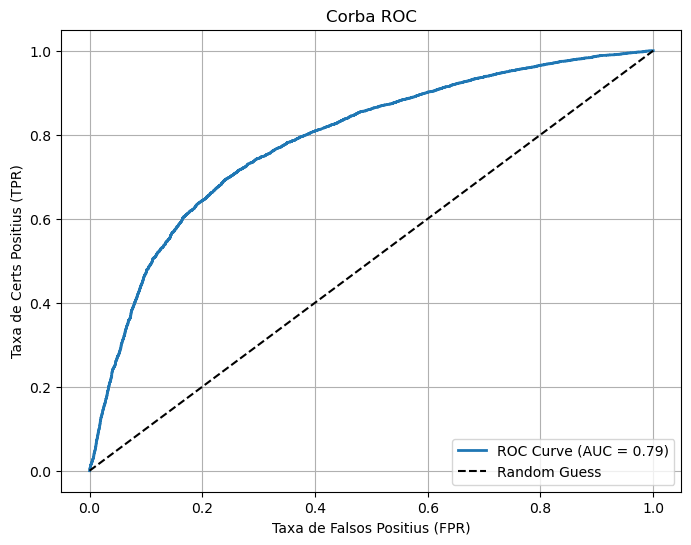

AUC: 0.7861532711934103


In [175]:
# Entrenar el model
log_reg.fit(X_train, y_train)

# Obtenir les probabilitats predites per al model
y_prob = log_reg.predict_proba(X_test)[:, 1]  # Només la probabilitat de la classe positiva

# Calcular els valors per a la corba ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Generar la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Corba ROC")
plt.xlabel("Taxa de Falsos Positius (FPR)")
plt.ylabel("Taxa de Certs Positius (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("AUC:", auc)



Valor de l'AUC:
- Un AUC de 0.786 indica que el model de Logistic Regression té una bona capacitat per diferenciar entre els pacients amb i sense malaltia cardiovascular. Això significa que, en general, el model classifica correctament les mostres positives i negatives amb una probabilitat del 78.6%.

Punts forts del model:
- El valor AUC > 0.75 suggereix que el model és fiable per a aquesta tasca de classificació. L'ús de Logistic Regression proporciona un model interpretable, especialment útil per analitzar quines variables tenen més pes en la predicció.

Limitacions i millores possibles:
- Tot i que el rendiment és acceptable, hi ha marge de millora amb models més complexos com Random Forest o XGBoost.

### Realització de millores
XGBoost (eXtreme Gradient Boosting) és un dels models més potents per tasques de classificació i regressió. Els motius principals per utilitzar-lo són:
- Alt rendiment:
    - XGBoost sovint supera altres models gràcies al seu mecanisme avançat d'aprenentatge basat en arbres.
- Robustesa:
    - Gestiona bé les dades amb outliers i les relacions complexes entre variables.
- Hiperparàmetres flexibles:
    - Permet un ajust fi del model per millorar el rendiment.
- Velocitat i eficàcia:
    - XGBoost està optimitzat per velocitat i consumeix menys recursos que altres implementacions de boosting.
- Maneig de variables categòriques:
    - Tot i que XGBoost no gestiona directament variables categòriques, en el nostre cas ja hem aplicat One-Hot Encoding, per la qual cosa està preparat per a treballar amb aquest dataset.

In [176]:
# Definir X i y
X = encoded_data.drop(columns=['cardio'])  # Variables predictors
y = encoded_data['cardio']  # Variable objectiu

# Divisió del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear DMatrix per XGBoost
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

# Configuració dels paràmetres del model
params = {
    "objective": "binary:logistic",
    "learning_rate": 0.1,
    "max_depth": 5,
    "eval_metric": "auc",
    "seed": 42
}

# Entrenar el model amb early stopping (monitoritza l'AUC a cada iteració i s'atura l'entrenament si no millora després de 5 iteracions)
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = train(params, dtrain, num_boost_round=50, evals=evals, early_stopping_rounds=5, verbose_eval=True)

# Prediccions i avaluació
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertir probabilitats a classes

# Càlcul de mètriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Mostrar resultats
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



[0]	train-auc:0.79411	eval-auc:0.78760
[1]	train-auc:0.79586	eval-auc:0.78895
[2]	train-auc:0.79797	eval-auc:0.79070
[3]	train-auc:0.79872	eval-auc:0.79052
[4]	train-auc:0.79943	eval-auc:0.79088
[5]	train-auc:0.79996	eval-auc:0.79133
[6]	train-auc:0.80034	eval-auc:0.79140
[7]	train-auc:0.80096	eval-auc:0.79175
[8]	train-auc:0.80141	eval-auc:0.79191
[9]	train-auc:0.80169	eval-auc:0.79218
[10]	train-auc:0.80203	eval-auc:0.79238
[11]	train-auc:0.80229	eval-auc:0.79236
[12]	train-auc:0.80271	eval-auc:0.79265
[13]	train-auc:0.80312	eval-auc:0.79295
[14]	train-auc:0.80360	eval-auc:0.79331
[15]	train-auc:0.80390	eval-auc:0.79354
[16]	train-auc:0.80419	eval-auc:0.79364
[17]	train-auc:0.80461	eval-auc:0.79408
[18]	train-auc:0.80493	eval-auc:0.79433
[19]	train-auc:0.80526	eval-auc:0.79441
[20]	train-auc:0.80548	eval-auc:0.79455
[21]	train-auc:0.80564	eval-auc:0.79453
[22]	train-auc:0.80590	eval-auc:0.79476
[23]	train-auc:0.80617	eval-auc:0.79499
[24]	train-auc:0.80640	eval-auc:0.79511
[25]	train

## Conclusió del Cas Kaggle: Predicció de Malalties Cardiovasculars

Després d'analitzar el dataset i entrenar diversos models, incloent-hi **Logistic Regression** i **XGBoost**, hem arribat a les següents conclusions:

### 1. Rendiment dels models:
- **Logistic Regression**:
  - Accuracy: 0.7275
  - Precision: 0.7440
  - Recall: 0.6855
  - F1 Score: 0.7136
  - Tot i ser un model senzill i interpretable, ha demostrat ser robust i ha servit com a bona línia base.

- **XGBoost** (model optimitzat amb early stopping):
  - Accuracy: 0.7295 (resultat del codi final)
  - Precision: 0.7506
  - Recall: 0.6790
  - F1 Score: 0.7130
  - XGBoost ha superat **Logistic Regression** en algunes mètriques, especialment en **Precision**, gràcies a la seva capacitat per capturar relacions complexes entre variables. No obstant això, el guany en **Accuracy** no ha estat significatiu.

### 2. Mètriques clau:
- **AUC de Logistic Regression**: 0.786
- Aquest resultat indica que el model té una bona capacitat per diferenciar entre pacients amb i sense malalties cardiovasculars.
- **XGBoost** ha mostrat un rendiment similar o lleugerament millor després d'afinar els hiperparàmetres.

### 3. Limitacions i consideracions:
- **Simplicitat vs Complexitat**:
  - **Logistic Regression** és més senzill d'interpretar i més ràpid d'entrenar.
  - **XGBoost**, tot i ser més potent, necessita més ajustos i temps d'entrenament.
- **Enginyeria de característiques**:
  - L'ús de variables com el colesterol i la glucosa amb **One-Hot Encoding** ha estat essencial per millorar el rendiment dels models.
- **Possibles millores**:
  - Explorar tècniques avançades d'enginyeria de característiques i tractament de desequilibris en la variable objectiu.

### 4. Conclusió final:
- El model XGBoost optimitzat proporciona un bon equilibri entre **Accuracy** i **Precision**, fent-lo adequat per a la detecció de casos positius amb un baix percentatge de falsos positius.
- Tot i això, el model de **Logistic Regression** és suficientment fiable per a una primera implementació gràcies a la seva simplicitat i interpretabilitat.
- Per a una aplicació pràctica, la decisió final dependrà de si el focus està en identificar més casos positius (**Recall**) o en minimitzar errors (**Precision**).

El projecte demostra que els algoritmes d'aprenentatge automàtic poden ser eines valuoses en la predicció de malalties cardiovasculars, amb un impacte positiu potencial en la salut pública.
